<a href="https://colab.research.google.com/github/mdeleond/Portfolio/blob/main/Projects/Montevideo%20Traffic%20accidents%20analysis/Siniestros_en_Montevideo_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Traffic accidents in Montevideo



#1.- Introduction
In this case, we'll be analyzing the Montevideo traffic accidents dataset for 2024. Each record is an accident with the features related to it (date, hour, day of week, category, severity and geographical coordinates), as will be seen on next chapter.

#2.- Data sets
We are going to use 3 data sets to assess the driver's behavior:


*   **The accidents dataset (1)**, to know the number and nature of siniestrality.
*   **The weather dataset(2)**, to link the accidents with weather features.
*   **The football matches dataset(3)**, to evaluate the impact of football matches on driver's psyque.
##2.1.- Source
  *   (1) is available publicly at [Geoportal de UNASEV](https://aplicacionesunasev.presidencia.gub.uy/mapas/AdministracionMapaIndicadores/AdministracionMapaIndicadores_Alta) (data repo of Office of National Road Safety, UNASEV)

  *   (2) is available publicly at the [Banco Agrometeorológico del INIA](https://www.inia.uy/gras/Clima/Banco-datos-agroclimatico) (Instituto de Investigación Agropecuaria, INIA)

  *   (3) we obtained scrapping from the AUF page



#3.- Setup and library imports

In [ ]:
!pip install plotly-calplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.5/506.5 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully uninstalled pytz-2025.2
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 r

In [ ]:
from google.colab import drive
from google.colab import userdata
route = userdata.get('proj_route')
drive.mount('/content/drive')
%cd -q {route}

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import datetime as dt
import scipy.stats as stats
from plotly_calplot import calplot
import plotly.graph_objects as go

#4.-Functions
Here we'll define all the functions needed to help getting the insights (ETL, tasks, etc.)


In [ ]:
"""This function checks every column on a given dataframe and removes the spaces at the start and end of each value.
"""
def remove_whitespace(y):
  for name in y.columns:
    if name != 'geometry':
      y[name] = y[name].apply(lambda value: str(value).strip())
  return y

In [ ]:
#Define some dictionaires to convert es-en weekday words
order = ['LUNES','MARTES','MIÉRCOLES','JUEVES','VIERNES','SÁBADO','DOMINGO']
order_en = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
order_dict = dict(zip(order,order_en))

#5.- Exploratory analysis

Loading the weather file. It contains several meteorological data, such as rain, fog, temperature, humidity,etc.

In [ ]:
weather = pd.read_csv('DatosDiariosConsulta_2024.csv')
weather

,,,,,,,,,INIA Las Brujas (LB)
Fecha,Heliofanía (Hrs.),Precip. Acumulada (mm),T. Media ((TM+Tm)/2) (ºC),Helada Meteo. (S:1/N:0),Heliofanía Relativa (%),Llovió (S:1/N:0),HR >=90% y <=99% (Horas),Humedad Rel. = 100% (Hrs),T.Min < 15ºC (S:1/N:0)
2024-01-01,9.2,0.0,22.2,0.0,64.5,0.0,4.0,0.0,0.0
2024-01-02,11.5,0.0,22.5,0.0,80.6,0.0,2.0,0.0,0.0
2024-01-03,12.9,0.0,23.2,0.0,90.5,0.0,5.0,0.0,0.0
2024-01-04,8.3,0.0,23.4,0.0,58.3,0.0,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
Cantidad de horas del día (0hrs a 24hrs) en que la Humedad Relativa estuvo igual o entre 90 % y 99%.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Humedad Rel. = 100% (Hrs),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cantidad de horas en el día (0hrs a 24hrs) que la Humedad Relativa fue igual a 100%.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T.Min < 15ºC (S:1/N:0),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Some rows are not in shape. Let's format that a bit.

In [ ]:
weather = pd.read_csv('DatosDiariosConsulta_2024.csv',header=1)
weather

,Fecha,Heliofanía (Hrs.),Precip. Acumulada (mm),T. Media ((TM+Tm)/2) (ºC),Helada Meteo. (S:1/N:0),Heliofanía Relativa (%),Llovió (S:1/N:0),HR >=90% y <=99% (Horas),Humedad Rel. = 100% (Hrs),T.Min < 15ºC (S:1/N:0)
0,2024-01-01,9.2,0.0,22.2,0.0,64.5,0.0,4.0,0.0,0.0
1,2024-01-02,11.5,0.0,22.5,0.0,80.6,0.0,2.0,0.0,0.0
2,2024-01-03,12.9,0.0,23.2,0.0,90.5,0.0,5.0,0.0,0.0
3,2024-01-04,8.3,0.0,23.4,0.0,58.3,0.0,5.0,0.0,0.0
4,2024-01-05,10.9,0.4,23.5,0.0,76.6,1.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
380,Cantidad de horas del día (0hrs a 24hrs) en qu...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
381,Humedad Rel. = 100% (Hrs),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
382,Cantidad de horas en el día (0hrs a 24hrs) que...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
383,T.Min < 15ºC (S:1/N:0),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


And there's some rows to remove yet. We''l be deleting them on next chapter. Now we'll try to open the .txt file containing the car accidents.

In [ ]:
with open('accidents_2024_mvd.txt', "r") as file:
    lines = file.readlines()
    first_line = lines[0]
    second_line = lines[1]
    third_line = lines[2]
    print(first_line)
    print(second_line,third_line)

Fecha, Calle, Tipo de Siniestro, Gravedad, Dia Semana, Hora, Departamento, Localidad, fixed, X, Y 

30/5/2024,, CAMINO AL PASO DEL ANDALUZ, COLISIÓN ENTRE VEHÍCULOS, LEVE, JUEVES, 17, MONTEVIDEO, MONTEVIDEO, 1, 578310, 6148715 
 1/8/2024,, MIGUELETE, COLISIÓN ENTRE VEHÍCULOS, GRAVE, JUEVES, 20, MONTEVIDEO, MONTEVIDEO, 1, 574765, 6138210 



Detected the file contained a double colon (,,) at some parts.

This is an issue as the colon is the separator which gives us the table structure, so it's necessary to remove them before passing it into a dataframe.

In [ ]:
reading_file = open('accidents_2024_mvd.txt', "r")
new_file_content = "" #We create an empty string to store the file content

for line in reading_file:
    stripped_line = line.strip()
    new_line = stripped_line.replace(",,", ",") # At every line, we check if there's a double colon and replace it by a single colon to fix the structure
    new_file_content += new_line +"\n"
reading_file.close()

writing_file = open('accidents_ok.txt', "w") # store the fixed file
writing_file.write(new_file_content)

writing_file.close()


In [ ]:
accidents = pd.read_csv('accidents_ok.txt', sep=",",index_col=False)
cols = list(accidents.columns)
cols = [col.strip().replace(' ', '_') for col in cols]
accidents.columns = cols
accidents = remove_whitespace(accidents) # to make sure there are no values with spaces at start or end (function defined on chapter 4)
accidents

,Fecha,Calle,Tipo_de_Siniestro,Gravedad,Dia_Semana,Hora,Departamento,Localidad,fixed,X,Y
0,30/5/2024,CAMINO AL PASO DEL ANDALUZ,COLISIÓN ENTRE VEHÍCULOS,LEVE,JUEVES,17,MONTEVIDEO,MONTEVIDEO,1,578310,6148715
1,1/8/2024,MIGUELETE,COLISIÓN ENTRE VEHÍCULOS,GRAVE,JUEVES,20,MONTEVIDEO,MONTEVIDEO,1,574765,6138210
2,10/4/2024,AVENIDA ITALIA,CAÍDA,LEVE,MIÉRCOLES,17,MONTEVIDEO,MONTEVIDEO,1,577155,6138700
3,27/3/2024,SIN DATOS,COLISIÓN ENTRE VEHÍCULOS,SIN LESIONADOS,MIÉRCOLES,22,MONTEVIDEO,SIN DATOS,1,560055,6147080
4,1/6/2024,AVENIDA DE LAS INSTRUCCIONES,COLISIÓN ENTRE VEHÍCULOS,LEVE,SÁBADO,14,MONTEVIDEO,MONTEVIDEO,1,573330,6144220
...,...,...,...,...,...,...,...,...,...,...,...
8414,19/4/2024,AVENIDA DOCTOR AMERICO RICALDONI,COLISIÓN ENTRE VEHÍCULOS,LEVE,VIERNES,15,MONTEVIDEO,MONTEVIDEO,1,577585,6138140
8415,20/7/2024,AVENIDA DOCTOR CARLOS MARIA RODRIGUEZ,DESPISTE,SIN LESIONADOS,SÁBADO,17,MONTEVIDEO,MONTEVIDEO,1,569295,6141050
8416,8/3/2024,CAMINO CARRASCO,COLISIÓN ENTRE VEHÍCULOS,LEVE,VIERNES,8,MONTEVIDEO,MONTEVIDEO,1,585580,6141180
8417,29/9/2024,CAMINO CORRALES,COLISIÓN ENTRE VEHÍCULOS,LEVE,DOMINGO,23,MONTEVIDEO,MONTEVIDEO,1,577310,6143570


In [ ]:
#search for duplicated rows
accidents[accidents.duplicated()==True]

,Fecha,Calle,Tipo_de_Siniestro,Gravedad,Dia_Semana,Hora,Departamento,Localidad,fixed,X,Y
1786,3/6/2024,AVENIDA JOSE BELLONI,ATROPELLO DE PEATÓN,LEVE,LUNES,15,MONTEVIDEO,MONTEVIDEO,1,578575,6146110
1875,8/4/2024,LUIS ENRIQUE AZAROLA GIL,COLISIÓN ENTRE VEHÍCULOS,LEVE,LUNES,12,MONTEVIDEO,MONTEVIDEO,1,577595,6146935
2096,11/1/2024,TURIN,COLISIÓN ENTRE VEHÍCULOS,LEVE,JUEVES,10,MONTEVIDEO,MONTEVIDEO,1,580490,6144830
3110,11/1/2024,TURIN,COLISIÓN ENTRE VEHÍCULOS,LEVE,JUEVES,10,MONTEVIDEO,MONTEVIDEO,1,580490,6144830
3905,11/1/2024,TURIN,COLISIÓN ENTRE VEHÍCULOS,LEVE,JUEVES,10,MONTEVIDEO,MONTEVIDEO,1,580490,6144830
4064,11/12/2024,AVENIDA ITALIA,COLISIÓN ENTRE VEHÍCULOS,SIN LESIONADOS,MIÉRCOLES,9,MONTEVIDEO,MONTEVIDEO,1,576510,6138400
4198,15/3/2024,AVENIDA DE LAS LEYES,CAÍDA,LEVE,VIERNES,5,MONTEVIDEO,MONTEVIDEO,1,574220,6138850
4954,11/1/2024,TURIN,COLISIÓN ENTRE VEHÍCULOS,LEVE,JUEVES,10,MONTEVIDEO,MONTEVIDEO,1,580490,6144830
5019,8/4/2024,AVENIDA OCHO DE OCTUBRE,COLISIÓN ENTRE VEHÍCULOS,LEVE,LUNES,14,MONTEVIDEO,MONTEVIDEO,1,578905,6140720
5084,21/7/2024,CAMINO CARRASCO,COLISIÓN ENTRE VEHÍCULOS,LEVE,DOMINGO,12,MONTEVIDEO,MONTEVIDEO,1,585545,6141165


##5.1.- Data preparation

Let's start with the weather dataset.

In [ ]:
weather.tail(20)

,Fecha,Heliofanía (Hrs.),Precip. Acumulada (mm),T. Media ((TM+Tm)/2) (ºC),Helada Meteo. (S:1/N:0),Heliofanía Relativa (%),Llovió (S:1/N:0),HR >=90% y <=99% (Horas),Humedad Rel. = 100% (Hrs),T.Min < 15ºC (S:1/N:0)
365,2024-12-31,12.4,0.0,23.2,0.0,86.9,0.0,6.0,0.0,0.0
366,Definición de las variables listadas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
367,Heliofanía (Hrs.),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
368,Heliofanía Hs se obtiene a partir de la “lectu...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369,Precip. Acumulada (mm),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
370,"Precipitación acumulada diaria, medida convenc...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
371,T. Media ((TM+Tm)/2) (ºC),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
372,Temperatura media del día calculada utilizando...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
373,Helada Meteo. (S:1/N:0),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
374,Cuando la lectura del termómetro de mínima en ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The last rows are the variable descriptions, we need to remove them or order to work with the dataset.

In [ ]:
weather = weather.iloc[:366] # quit descriptions at the bottom of .csv file
weather

,Fecha,Heliofanía (Hrs.),Precip. Acumulada (mm),T. Media ((TM+Tm)/2) (ºC),Helada Meteo. (S:1/N:0),Heliofanía Relativa (%),Llovió (S:1/N:0),HR >=90% y <=99% (Horas),Humedad Rel. = 100% (Hrs),T.Min < 15ºC (S:1/N:0)
0,2024-01-01,9.2,0.0,22.2,0.0,64.5,0.0,4.0,0.0,0.0
1,2024-01-02,11.5,0.0,22.5,0.0,80.6,0.0,2.0,0.0,0.0
2,2024-01-03,12.9,0.0,23.2,0.0,90.5,0.0,5.0,0.0,0.0
3,2024-01-04,8.3,0.0,23.4,0.0,58.3,0.0,5.0,0.0,0.0
4,2024-01-05,10.9,0.4,23.5,0.0,76.6,1.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
361,2024-12-27,12.1,0.0,18.7,0.0,100.0,0.0,9.0,0.0,1.0
362,2024-12-28,2.8,0.0,17.1,0.0,49.0,0.0,6.0,0.0,1.0
363,2024-12-29,11.9,0.0,17.7,0.0,83.3,0.0,2.0,3.0,1.0
364,2024-12-30,10.2,0.0,20.4,0.0,71.4,0.0,5.0,0.0,1.0


In [ ]:
weather.columns = ['Fecha','Hel_hrs', 'Rain_mm','T_med','Frost_b','Hel_rel', 'Rain_b','HR_90_99_hrs',
                   'HR_100_hrs','T_min_15_b']
                   # rename columns
weather.head(1)

,Fecha,Hel_hrs,Rain_mm,T_med,Frost_b,Hel_rel,Rain_b,HR_90_99_hrs,HR_100_hrs,T_min_15_b
0,2024-01-01,9.2,0.0,22.2,0.0,64.5,0.0,4.0,0.0,0.0


In [ ]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Fecha         366 non-null    object 
 1   Hel_hrs       366 non-null    float64
 2   Rain_mm       365 non-null    float64
 3   T_med         365 non-null    float64
 4   Frost_b       365 non-null    float64
 5   Hel_rel       365 non-null    float64
 6   Rain_b        365 non-null    float64
 7   HR_90_99_hrs  365 non-null    float64
 8   HR_100_hrs    365 non-null    float64
 9   T_min_15_b    365 non-null    float64
dtypes: float64(9), object(1)
memory usage: 28.7+ KB


There's a row with NAN values, we will look for it.

In [ ]:
weather[weather.isna().any(axis=1)]

,Fecha,Hel_hrs,Rain_mm,T_med,Frost_b,Hel_rel,Rain_b,HR_90_99_hrs,HR_100_hrs,T_min_15_b
352,2024-12-18,12.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The only available feature is sunshine duration. We will find dates with similar sunshine duration.

In [ ]:
weather[weather['Hel_hrs']==12.6]

,Fecha,Hel_hrs,Rain_mm,T_med,Frost_b,Hel_rel,Rain_b,HR_90_99_hrs,HR_100_hrs,T_min_15_b
24,2024-01-25,12.6,0.0,23.3,0.0,90.9,0.0,4.0,0.0,0.0
319,2024-11-15,12.6,0.0,22.5,0.0,100.0,0.0,0.0,0.0,1.0
334,2024-11-30,12.6,1.5,17.9,0.0,100.0,1.0,6.0,0.0,1.0
352,2024-12-18,12.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


A fair assumption is to replace the NaN values with the nearest day with same sunshine duration values.

In [ ]:
weather.iloc[352,1:] = weather.iloc[334,1:]
weather[weather['Hel_hrs']==12.6]

,Fecha,Hel_hrs,Rain_mm,T_med,Frost_b,Hel_rel,Rain_b,HR_90_99_hrs,HR_100_hrs,T_min_15_b
24,2024-01-25,12.6,0.0,23.3,0.0,90.9,0.0,4.0,0.0,0.0
319,2024-11-15,12.6,0.0,22.5,0.0,100.0,0.0,0.0,0.0,1.0
334,2024-11-30,12.6,1.5,17.9,0.0,100.0,1.0,6.0,0.0,1.0
352,2024-12-18,12.6,1.5,17.9,0.0,100.0,1.0,6.0,0.0,1.0


In [ ]:
print(weather.dtypes)

Fecha            object
Hel_hrs         float64
Rain_mm         float64
T_med           float64
Frost_b         float64
Hel_rel         float64
Rain_b          float64
HR_90_99_hrs    float64
HR_100_hrs      float64
T_min_15_b      float64
dtype: object


In [ ]:
print(weather.HR_100_hrs.unique())
print(weather.HR_90_99_hrs.unique())
#both columns have only integers

[ 0.  1.  5. 12.  9.  2.  7. 15. 17. 10.  3.  4.  6. 11. 19.  8. 16. 18.
 22. 14.]
[ 4.  2.  5.  7.  8.  1. 12.  9.  3.  6.  0. 11. 14. 15. 13. 10. 22. 19.
 20. 16. 17. 21. 18.]


In [ ]:
weather = weather.astype({'Fecha':'datetime64[ns]',
                          'Hel_hrs':'float',
                          'Rain_mm':'float',
                          'T_med':'float',
                          'Frost_b':'bool',
                          'Hel_rel':'float',
                          'Rain_b':'bool',
                          'HR_90_99_hrs':'int',
                          'HR_100_hrs':'int',
                          'T_min_15_b':'bool'})
print(weather.dtypes)
weather

Fecha           datetime64[ns]
Hel_hrs                float64
Rain_mm                float64
T_med                  float64
Frost_b                   bool
Hel_rel                float64
Rain_b                    bool
HR_90_99_hrs             int64
HR_100_hrs               int64
T_min_15_b                bool
dtype: object


,Fecha,Hel_hrs,Rain_mm,T_med,Frost_b,Hel_rel,Rain_b,HR_90_99_hrs,HR_100_hrs,T_min_15_b
0,2024-01-01,9.2,0.0,22.2,False,64.5,False,4,0,False
1,2024-01-02,11.5,0.0,22.5,False,80.6,False,2,0,False
2,2024-01-03,12.9,0.0,23.2,False,90.5,False,5,0,False
3,2024-01-04,8.3,0.0,23.4,False,58.3,False,5,0,False
4,2024-01-05,10.9,0.4,23.5,False,76.6,True,4,0,False
...,...,...,...,...,...,...,...,...,...,...
361,2024-12-27,12.1,0.0,18.7,False,100.0,False,9,0,True
362,2024-12-28,2.8,0.0,17.1,False,49.0,False,6,0,True
363,2024-12-29,11.9,0.0,17.7,False,83.3,False,2,3,True
364,2024-12-30,10.2,0.0,20.4,False,71.4,False,5,0,True


Let's move on the accidents dataset.

In [ ]:
accidents.drop_duplicates(inplace=True)

In [ ]:
accidents.info()
accidents.dtypes

<class 'pandas.core.frame.DataFrame'>
Index: 8398 entries, 0 to 8418
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Fecha              8398 non-null   object
 1   Calle              8398 non-null   object
 2   Tipo_de_Siniestro  8398 non-null   object
 3   Gravedad           8398 non-null   object
 4   Dia_Semana         8398 non-null   object
 5   Hora               8398 non-null   object
 6   Departamento       8398 non-null   object
 7   Localidad          8398 non-null   object
 8   fixed              8398 non-null   object
 9   X                  8398 non-null   object
 10  Y                  8398 non-null   object
dtypes: object(11)
memory usage: 787.3+ KB


,0
Fecha,object
Calle,object
Tipo_de_Siniestro,object
Gravedad,object
Dia_Semana,object
Hora,object
Departamento,object
Localidad,object
fixed,object
X,object


In [ ]:
#Change dtypes to match every column values
accidents = accidents.astype({'Fecha':'datetime64[ns]',
                              'Hora':'int',
                              'fixed':'int',
                              'X':'int',
                              'Y':'int'})

In [ ]:
accidents.dtypes

,0
Fecha,datetime64[ns]
Calle,object
Tipo_de_Siniestro,object
Gravedad,object
Dia_Semana,object
Hora,int64
Departamento,object
Localidad,object
fixed,int64
X,int64


Finally, upload and work with matches dataset.

In [ ]:
matches = pd.read_csv('matches_2024.csv')
matches

,Date,Cup,Team1,Team2,Score,Venue
0,2024-11-19 21:45:00,Eliminatorias Mundial de la FIFA 2026,Brasil,Uruguay,1 - 1,"Estádio Fonte Nova, Salvador, Bahia, Brasil"
1,2024-11-15 21:00:00,Eliminatorias Mundial de la FIFA 2026,Uruguay,Colombia,3 - 2,"Estadio Centenario, Montevideo, Uruguay"
2,2024-10-15 20:30:00,Eliminatorias Mundial de la FIFA 2026,Uruguay,Ecuador,0 - 0,"Estadio Centenario, Montevideo"
3,2024-10-11 22:30:00,Eliminatorias Mundial de la FIFA 2026,Perú,Uruguay,1 - 0,"Estadio Nacional José Díaz, Lima, Perú"
4,2024-09-10 19:00:00,Eliminatorias Mundial de la FIFA 2026,Venezuela,Uruguay,0 - 0,"Estadio Monumental, Maturín, Venezuela"
5,2024-09-06 20:30:00,Eliminatorias Mundial de la FIFA 2026,Uruguay,Paraguay,0 - 0,"Estadio Centenario, Montevideo, Uruguay"
6,2024-07-13 21:00:00,CONMEBOL Copa América USA 2024,Canadá,Uruguay,(3) 2 - 2 (4),"Bank of America, Charlotte, Estados Unidos"
7,2024-07-10 21:00:00,CONMEBOL Copa América USA 2024,Uruguay,Colombia,0 - 1,"Bank of America, Charlotte, Estados Unidos"
8,2024-07-06 22:00:00,CONMEBOL Copa América USA 2024,Uruguay,Brasil,(4) 0 - 0 (2),"Allegiant Stadium Nevada, Las Vegas, Estados U..."
9,2024-07-01 22:00:00,CONMEBOL Copa América USA 2024,Estados Unid...,Uruguay,0 - 1,"Arrowhead Stadium, Kansas City, Estados Unidos"


In [ ]:
matches.dtypes

,0
Date,object
Cup,object
Team1,object
Team2,object
Score,object
Venue,object


In [ ]:
matches.Date=matches.Date.astype('datetime64[ns]')

In [ ]:
matches.dtypes

,0
Date,datetime64[ns]
Cup,object
Team1,object
Team2,object
Score,object
Venue,object


Let's see the local football tournament:

In [ ]:
local_matches = pd.read_csv('uruleague_matches_2024.csv')
local_matches

,Fecha,Hora,Equipo1,Equipo2,Resultado,ref
0,16/02/2024,20:30,Nacional,River Plate,2 - 1,NAC-RIV
1,17/02/2024,17:00,Fénix,Danubio,1 - 2,FEN-DAN
2,17/02/2024,21:30,D. Maldonado,Boston River,1 - 2,CDM-BRI
3,17/02/2024,19:15,Miramar Misiones,Progreso,2 - 3,MMI-PRO
4,18/02/2024,17:00,Racing,Liverpool,2 - 2,RAC-LIV
...,...,...,...,...,...,...
235,30/11/2024,09:45,Cerro,Liverpool,1 - 3,CRR-LIV
236,01/12/2024,18:00,Peñarol,Fénix,3 - 1,PEÑ-FEN
237,01/12/2024,09:45,Racing,River Plate,2 - 0,RAC-RIV
238,01/12/2024,18:00,Nacional,Boston River,3 - 1,NAC-BRI


In [ ]:
local_matches.dtypes

,0
Fecha,object
Hora,object
Equipo1,object
Equipo2,object
Resultado,object
ref,object


In [ ]:
local_matches['Fecha'] = pd.to_datetime(local_matches['Fecha'])
local_matches['Hora'] = pd.to_datetime(local_matches['Hora'],format='%H:%M').dt.hour
local_matches

/tmp/ipython-input-3678612994.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  local_matches['Fecha'] = pd.to_datetime(local_matches['Fecha'])


,Fecha,Hora,Equipo1,Equipo2,Resultado,ref
0,2024-02-16,20,Nacional,River Plate,2 - 1,NAC-RIV
1,2024-02-17,17,Fénix,Danubio,1 - 2,FEN-DAN
2,2024-02-17,21,D. Maldonado,Boston River,1 - 2,CDM-BRI
3,2024-02-17,19,Miramar Misiones,Progreso,2 - 3,MMI-PRO
4,2024-02-18,17,Racing,Liverpool,2 - 2,RAC-LIV
...,...,...,...,...,...,...
235,2024-11-30,9,Cerro,Liverpool,1 - 3,CRR-LIV
236,2024-12-01,18,Peñarol,Fénix,3 - 1,PEÑ-FEN
237,2024-12-01,9,Racing,River Plate,2 - 0,RAC-RIV
238,2024-12-01,18,Nacional,Boston River,3 - 1,NAC-BRI


In [ ]:
local_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha      240 non-null    datetime64[ns]
 1   Hora       240 non-null    int32         
 2   Equipo1    240 non-null    object        
 3   Equipo2    240 non-null    object        
 4   Resultado  240 non-null    object        
 5   ref        240 non-null    object        
dtypes: datetime64[ns](1), int32(1), object(4)
memory usage: 10.4+ KB


##5.2.- Data exploration

###5.2.a.- Traffic accidents

Let's start looking at the values on several columns, starting by the categorical ones:

In [ ]:
accidents.Dia_Semana.unique(), accidents.Tipo_de_Siniestro.unique(), accidents.Gravedad.unique(), accidents.Localidad.unique()

(array(['JUEVES', 'MIÉRCOLES', 'SÁBADO', 'LUNES', 'MARTES', 'DOMINGO',
        'VIERNES'], dtype=object),
 array(['COLISIÓN ENTRE VEHÍCULOS', 'CAÍDA', 'DESPISTE',
        'ATROPELLO DE PEATÓN', 'ATROPELLO DE ANIMALES',
        'COLISIÓN CON OBSTÁCULO EN CALZADA'], dtype=object),
 array(['LEVE', 'GRAVE', 'SIN LESIONADOS', 'FATAL'], dtype=object),
 array(['MONTEVIDEO', 'SIN DATOS'], dtype=object))

Everything seems reasonable, maybe should check the Localidad column with values 'SIN DATOS' (no data)

In [ ]:
accidents.Fecha.nunique() #if complete, there will be 366 distinct values (2024 was a leap year)

366

Which seems right too. Let's explore how the records are distributed on each feature:

In [ ]:
accidents.Gravedad.value_counts()

,count
Gravedad,
LEVE,5936
SIN LESIONADOS,1314
GRAVE,1049
FATAL,99


Severity has 4 categories:
* No injured
* Shallow
* Severe
* Fatal



In [ ]:
accidents.Dia_Semana.value_counts()

,count
Dia_Semana,
VIERNES,1322
MARTES,1292
MIÉRCOLES,1288
JUEVES,1287
LUNES,1252
SÁBADO,1059
DOMINGO,898


Fridays are the day with most accidents, and Sundays have the least accident records

In [ ]:
accidents.Tipo_de_Siniestro.value_counts()

,count
Tipo_de_Siniestro,
COLISIÓN ENTRE VEHÍCULOS,6044
ATROPELLO DE PEATÓN,916
CAÍDA,732
DESPISTE,420
COLISIÓN CON OBSTÁCULO EN CALZADA,182
ATROPELLO DE ANIMALES,104


The most common accident is car crash. It's interesting to see pedestrian casualties being the second most common casualty.

In [ ]:
accidents.Hora.value_counts().sort_values(ascending=False).head(5)

,count
Hora,
17,674
18,660
16,571
15,533
14,510


The time when most accidents occur are between 14:00-18:00, with 17:00 being the most crowded with accidents.

In [ ]:
accidents['Mes'] = accidents['Fecha'].dt.month_name()
monthly_accidents = accidents.Mes.value_counts().reset_index()
monthly_accidents

,Mes,count
0,September,764
1,October,762
2,June,762
3,November,754
4,May,746
5,August,716
6,December,714
7,April,709
8,July,678
9,March,625


September is the month when most accidents occurred. October and June follow closely with 762 accidents each.

In [ ]:
year_2024 = pd.DataFrame(columns=['Date'])
year_2024['Date'] = pd.Series(pd.date_range("1/1/2024", freq="D", periods=366))
year_2024['DoW'] = year_2024['Date'].dt.day_name()
year_2024

,Date,DoW
0,2024-01-01,Monday
1,2024-01-02,Tuesday
2,2024-01-03,Wednesday
3,2024-01-04,Thursday
4,2024-01-05,Friday
...,...,...
361,2024-12-27,Friday
362,2024-12-28,Saturday
363,2024-12-29,Sunday
364,2024-12-30,Monday


In [ ]:
peak_accidents = accidents.groupby(['Dia_Semana','Hora']).agg({'fixed':'sum'}).reset_index() #add all the accidents for each day and hour
accidents_daily = accidents.Dia_Semana.value_counts().reset_index()
accidents_daily['count'] = accidents_daily['count']/len(year_2024[year_2024['DoW'].isin(
    [order_dict[day] for day in accidents_daily['Dia_Semana']])])
accidents_daily

,Dia_Semana,count
0,VIERNES,3.612022
1,MARTES,3.530055
2,MIÉRCOLES,3.519126
3,JUEVES,3.516393
4,LUNES,3.420765
5,SÁBADO,2.893443
6,DOMINGO,2.453552


In [ ]:
peak_accidents['fixed'] = peak_accidents['fixed']/len(year_2024[year_2024['DoW'].isin(
    [order_dict[day] for day in peak_accidents['Dia_Semana']])]) #compute the mean of accidents distributed along every day of the week and hour

peak_accidents.sort_values(by='fixed',ascending=False).head(12)

,Dia_Semana,Hora,fixed
41,JUEVES,17,0.363388
89,MARTES,17,0.349727
90,MARTES,18,0.319672
113,MIÉRCOLES,17,0.311475
42,JUEVES,18,0.306011
114,MIÉRCOLES,18,0.292350
162,VIERNES,18,0.284153
66,LUNES,18,0.270492
161,VIERNES,17,0.267760
40,JUEVES,16,0.262295


The average accidents per hour concentrates on 17:00-18:00, being Tuesday - Thursday the most populated days.

###5.2.b.- Weather dataset

In [ ]:
weather.describe()

,Fecha,Hel_hrs,Rain_mm,T_med,Hel_rel,HR_90_99_hrs,HR_100_hrs
count,366,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,2024-07-01 12:00:00.000000256,7.201202,2.952186,16.411202,78.529781,6.685792,1.961749
min,2024-01-01 00:00:00,0.000000,0.000000,2.900000,0.000000,0.000000,0.000000
25%,2024-04-01 06:00:00,3.725000,0.000000,11.600000,64.625000,3.000000,0.000000
50%,2024-07-01 12:00:00,8.150000,0.000000,16.800000,94.550000,6.000000,0.000000
75%,2024-09-30 18:00:00,10.300000,0.500000,21.075000,100.000000,10.000000,2.000000
max,2024-12-31 00:00:00,14.000000,68.000000,29.700000,100.000000,22.000000,22.000000
std,NaN,4.038303,8.995785,5.770844,29.768745,4.924322,3.864650


In [ ]:
weather[(weather['Rain_b']==True)&(weather['Rain_mm']==0)|(weather['Rain_b']==False)&(weather['Rain_mm']>0)]

,Fecha,Hel_hrs,Rain_mm,T_med,Frost_b,Hel_rel,Rain_b,HR_90_99_hrs,HR_100_hrs,T_min_15_b


The boolean value for *Rain_b* works correctly.

In [ ]:
weather[weather['Frost_b']==True]

,Fecha,Hel_hrs,Rain_mm,T_med,Frost_b,Hel_rel,Rain_b,HR_90_99_hrs,HR_100_hrs,T_min_15_b
181,2024-06-30,8.6,0.0,6.4,True,100.0,False,6,0,True
186,2024-07-05,9.2,0.0,5.4,True,100.0,False,6,0,True
187,2024-07-06,7.4,0.0,4.8,True,100.0,False,9,0,True
189,2024-07-08,4.1,0.3,3.5,True,100.0,True,10,0,True
191,2024-07-10,7.2,0.0,4.3,True,86.5,False,14,0,True
192,2024-07-11,7.5,0.0,2.9,True,88.3,False,5,9,True
193,2024-07-12,8.5,0.0,5.6,True,96.3,False,11,0,True
194,2024-07-13,8.5,0.0,5.0,True,94.1,False,5,10,True
195,2024-07-14,8.5,0.0,4.9,True,91.9,False,7,6,True
196,2024-07-15,8.6,0.0,7.4,True,100.0,False,1,8,True


The frost values are true for winter months (June and July) which is consistent with weather behavior.

Another dataset is the hourly solar radiation from Montevideo, which assigns a value every 10 minutes.

In [152]:
radiacion_1 = pd.read_csv('radiacion_solar_01_2024_04_2024.csv')
radiacion_1.sample(5)

,fecha_medida,indice_uv
14883,2024-02-26 10:17:55,1.005
20989,2024-01-31 08:18:53,2.247
8864,2024-03-23 04:41:43,0.000
4953,2024-04-08 18:45:58,0.000
12170,2024-03-08 23:42:23,0.000


In [156]:
radiacion_1.describe()

,indice_uv
count,27426.000000
mean,2.826063
std,3.995535
min,0.000000
25%,0.000000
50%,0.452000
75%,4.771000
max,14.779000


In [157]:
radiacion_2 = pd.read_csv('radiacion_solar_05_2024_08_2024.csv')
radiacion_3 = pd.read_csv('radiacion_solar_09_2024_12_2024.csv')

radiacion_mvd_2024 = pd.concat([radiacion_1,radiacion_2,radiacion_3])
radiacion_mvd_2024['fecha_medida']=pd.to_datetime(radiacion_mvd_2024['fecha_medida'])
radiacion_mvd_2024['Fecha'] = radiacion_mvd_2024['fecha_medida'].dt.date

radiacion_mvd_2024['Hora'] = radiacion_mvd_2024['fecha_medida'].dt.hour
radiacion_mvd_2024 = radiacion_mvd_2024.astype({'Fecha':'datetime64[ns]',
                              'Hora':'int',
                              'indice_uv':'float'})
radiacion_mvd_2024

,fecha_medida,indice_uv,Fecha,Hora
0,2024-04-29 23:59:58,0.0,2024-04-29,23
1,2024-04-29 23:49:58,0.0,2024-04-29,23
2,2024-04-29 23:39:58,0.0,2024-04-29,23
3,2024-04-29 23:29:58,0.0,2024-04-29,23
4,2024-04-29 23:19:58,0.0,2024-04-29,23
...,...,...,...,...
28289,2024-09-01 00:44:43,0.0,2024-09-01,0
28290,2024-09-01 00:34:43,0.0,2024-09-01,0
28291,2024-09-01 00:24:43,0.0,2024-09-01,0
28292,2024-09-01 00:14:43,0.0,2024-09-01,0


##5.3.-Organizing and connecting data families
Now that we have the data cleaned, we can make associations and reveal insights.

###5.3.a.- Accidents vs. Weather

In [ ]:
accidents_day = accidents.groupby('Fecha').agg({'fixed':'sum'}).reset_index()
accidents_day.rename(columns={'fixed':'accidents'},inplace=True)
accidents_day

,Fecha,accidents
0,2024-01-01,8
1,2024-01-02,20
2,2024-01-03,20
3,2024-01-04,20
4,2024-01-05,15
...,...,...
361,2024-12-27,19
362,2024-12-28,16
363,2024-12-29,15
364,2024-12-30,23


In [ ]:
accidents_weather = pd.merge(accidents_day,weather,on='Fecha',how='right')
accidents_weather['DoW'] = accidents_weather['Fecha'].dt.day_name()
accidents_weather

,Fecha,accidents,Hel_hrs,Rain_mm,T_med,Frost_b,Hel_rel,Rain_b,HR_90_99_hrs,HR_100_hrs,T_min_15_b,DoW
0,2024-01-01,8,9.2,0.0,22.2,False,64.5,False,4,0,False,Monday
1,2024-01-02,20,11.5,0.0,22.5,False,80.6,False,2,0,False,Tuesday
2,2024-01-03,20,12.9,0.0,23.2,False,90.5,False,5,0,False,Wednesday
3,2024-01-04,20,8.3,0.0,23.4,False,58.3,False,5,0,False,Thursday
4,2024-01-05,15,10.9,0.4,23.5,False,76.6,True,4,0,False,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...
361,2024-12-27,19,12.1,0.0,18.7,False,100.0,False,9,0,True,Friday
362,2024-12-28,16,2.8,0.0,17.1,False,49.0,False,6,0,True,Saturday
363,2024-12-29,15,11.9,0.0,17.7,False,83.3,False,2,3,True,Sunday
364,2024-12-30,23,10.2,0.0,20.4,False,71.4,False,5,0,True,Monday


In [ ]:
accidents_weather.iloc[:,:-1].corr()

,Fecha,accidents,Hel_hrs,Rain_mm,T_med,Frost_b,Hel_rel,Rain_b,HR_90_99_hrs,HR_100_hrs,T_min_15_b
Fecha,1.000000,0.241360,0.041813,-0.079844,-0.280284,0.019604,0.217177,-0.043908,-0.097357,0.167696,0.382612
accidents,0.241360,1.000000,-0.052511,-0.008546,-0.148962,-0.038381,0.092758,-0.055201,-0.015877,0.095244,0.185827
Hel_hrs,0.041813,-0.052511,1.000000,-0.334129,0.263244,0.035708,0.765588,-0.493535,-0.542636,-0.359799,0.028922
Rain_mm,-0.079844,-0.008546,-0.334129,1.000000,0.108832,-0.059992,-0.412367,0.482436,0.322052,0.113309,-0.189787
T_med,-0.280284,-0.148962,0.263244,0.108832,1.000000,-0.358974,-0.137198,0.082536,-0.107103,-0.298077,-0.685251
Frost_b,0.019604,-0.038381,0.035708,-0.059992,-0.358974,1.000000,0.110831,-0.092439,0.018004,0.053506,0.113665
Hel_rel,0.217177,0.092758,0.765588,-0.412367,-0.137198,0.110831,1.000000,-0.458914,-0.406512,-0.285053,0.283665
Rain_b,-0.043908,-0.055201,-0.493535,0.482436,0.082536,-0.092439,-0.458914,1.000000,0.369519,0.161949,-0.183775
HR_90_99_hrs,-0.097357,-0.015877,-0.542636,0.322052,-0.107103,0.018004,-0.406512,0.369519,1.000000,-0.056779,-0.079221
HR_100_hrs,0.167696,0.095244,-0.359799,0.113309,-0.298077,0.053506,-0.285053,0.161949,-0.056779,1.000000,0.169683


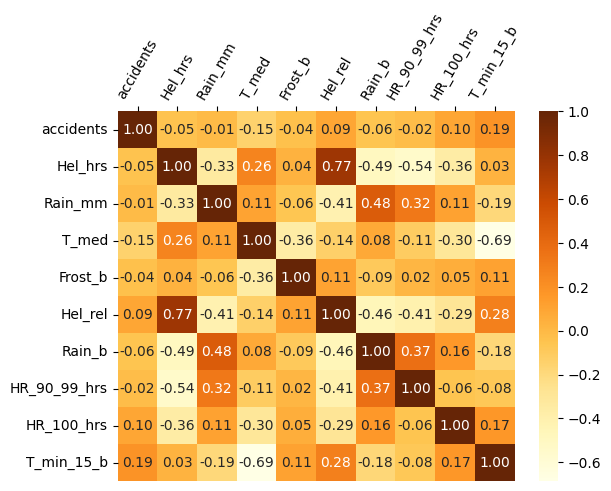

In [ ]:
accidents_weather_no_date = accidents_weather.drop(columns=['Fecha','DoW'])

fig, ax = plt.subplots()
sns.heatmap(accidents_weather_no_date.corr(method='pearson'), annot=True, fmt='1.2f',robust=False,cmap="YlOrBr")
#plt.title('On average, Tuesdays and Thursdays \n have the highest number of accidents per day per hour at 5pm.',loc='left',fontweight="light")
#ax.set(xlabel="Day", ylabel="Hour")
ax.xaxis.tick_top()
plt.xticks(rotation=60)
plt.yticks(rotation=0)
plt.show()

Let's test if there's any correlation taking into account only diurnal accidents.

In [ ]:
accidents_diurnal = accidents[(accidents['Hora']<19)&(accidents['Hora']>6)].groupby('Fecha').agg({'fixed':'sum'}).reset_index()
accidents_diurnal.rename(columns={'fixed':'accidents'},inplace=True)
accidents_diurnal

,Fecha,accidents
0,2024-01-01,4
1,2024-01-02,17
2,2024-01-03,13
3,2024-01-04,12
4,2024-01-05,11
...,...,...
361,2024-12-27,14
362,2024-12-28,9
363,2024-12-29,9
364,2024-12-30,15


In [ ]:
accidents_diurnal_weather = pd.merge(accidents_diurnal,weather,on='Fecha',how='right').drop(columns=['Fecha'])
accidents_diurnal_weather

,accidents,Hel_hrs,Rain_mm,T_med,Frost_b,Hel_rel,Rain_b,HR_90_99_hrs,HR_100_hrs,T_min_15_b
0,4,9.2,0.0,22.2,False,64.5,False,4,0,False
1,17,11.5,0.0,22.5,False,80.6,False,2,0,False
2,13,12.9,0.0,23.2,False,90.5,False,5,0,False
3,12,8.3,0.0,23.4,False,58.3,False,5,0,False
4,11,10.9,0.4,23.5,False,76.6,True,4,0,False
...,...,...,...,...,...,...,...,...,...,...
361,14,12.1,0.0,18.7,False,100.0,False,9,0,True
362,9,2.8,0.0,17.1,False,49.0,False,6,0,True
363,9,11.9,0.0,17.7,False,83.3,False,2,3,True
364,15,10.2,0.0,20.4,False,71.4,False,5,0,True


In [ ]:
accidents_diurnal_weather.corr()

,accidents,Hel_hrs,Rain_mm,T_med,Frost_b,Hel_rel,Rain_b,HR_90_99_hrs,HR_100_hrs,T_min_15_b
accidents,1.000000,-0.039860,-0.029306,-0.144050,-0.020190,0.095577,-0.085289,-0.017673,0.099863,0.167206
Hel_hrs,-0.039860,1.000000,-0.334129,0.263244,0.035708,0.765588,-0.493535,-0.542636,-0.359799,0.028922
Rain_mm,-0.029306,-0.334129,1.000000,0.108832,-0.059992,-0.412367,0.482436,0.322052,0.113309,-0.189787
T_med,-0.144050,0.263244,0.108832,1.000000,-0.358974,-0.137198,0.082536,-0.107103,-0.298077,-0.685251
Frost_b,-0.020190,0.035708,-0.059992,-0.358974,1.000000,0.110831,-0.092439,0.018004,0.053506,0.113665
Hel_rel,0.095577,0.765588,-0.412367,-0.137198,0.110831,1.000000,-0.458914,-0.406512,-0.285053,0.283665
Rain_b,-0.085289,-0.493535,0.482436,0.082536,-0.092439,-0.458914,1.000000,0.369519,0.161949,-0.183775
HR_90_99_hrs,-0.017673,-0.542636,0.322052,-0.107103,0.018004,-0.406512,0.369519,1.000000,-0.056779,-0.079221
HR_100_hrs,0.099863,-0.359799,0.113309,-0.298077,0.053506,-0.285053,0.161949,-0.056779,1.000000,0.169683
T_min_15_b,0.167206,0.028922,-0.189787,-0.685251,0.113665,0.283665,-0.183775,-0.079221,0.169683,1.000000


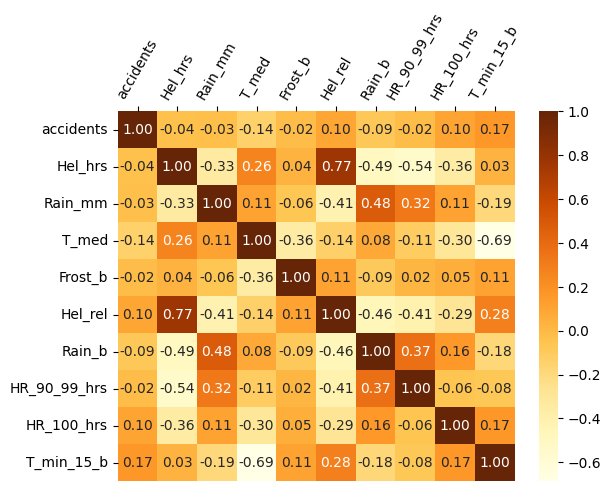

In [ ]:
fig, ax = plt.subplots()
sns.heatmap(accidents_diurnal_weather.corr(method='pearson'), annot=True, fmt='1.2f',robust=False,cmap="YlOrBr")
#plt.title('On average, Tuesdays and Thursdays \n have the highest number of accidents per day per hour at 5pm.',loc='left',fontweight="light")
#ax.set(xlabel="Day", ylabel="Hour")
ax.xaxis.tick_top()
plt.xticks(rotation=60)
plt.yticks(rotation=0)
plt.show()

It seems that there's not a correlation between number of accidents all over the city and weather features.

In [ ]:
accidents_weather.groupby(['DoW','Rain_b']).agg({'accidents':'mean'}).round(2)

accidents
DoW       Rain_b           
Friday    False       24.62
          True        22.13
Monday    False       22.94
          True        22.95
Saturday  False       21.31
          True        20.50
Sunday    False       19.94
          True        20.81
Thursday  False       23.37
          True        25.14
Tuesday   False       23.53
          True        22.87
Wednesday False       25.52
          True        24.50

Mean accidents count on sunny days vs rainy days does not provide any particular insight over these variables

In [ ]:
accidents_weather.groupby(['DoW','T_min_15_b']).agg({'accidents':'mean'}).round(2).sort_index()

accidents
DoW       T_min_15_b           
Friday    False           21.33
          True            24.95
Monday    False           19.86
          True            24.05
Saturday  False           19.31
          True            21.56
Sunday    False           19.89
          True            20.52
Thursday  False           23.00
          True            24.16
Tuesday   False           21.87
          True            23.92
Wednesday False           23.09
          True            25.88

Mean accidents count on cold days (minimum temp. less than 15°C) seems to have an effect over accidents, but not directly, as of cosenquense of temperature on traffic volume as people tend to choose cars on cold days.

Now we are working on the solar radiation dataset:

In [ ]:
radiacion_hr = radiacion_mvd_2024.groupby(['Fecha','Hora']).agg({'indice_uv':'mean'}).reset_index()
radiacion_hr

,Fecha,Hora,indice_uv
0,2024-01-01,0,0.000000
1,2024-01-01,1,0.000000
2,2024-01-01,2,0.000000
3,2024-01-01,3,0.000000
4,2024-01-01,4,0.000000
...,...,...,...
8640,2024-12-30,19,0.114667
8641,2024-12-30,20,0.000000
8642,2024-12-30,21,0.000000
8643,2024-12-30,22,0.000000


In [ ]:
accidents_hr = accidents.groupby(['Fecha','Hora']).agg({'fixed':'sum'}).reset_index()
accidents_hr.rename(columns={'fixed':'accidents'},inplace=True)
accidents_hr.dtypes

,0
Fecha,datetime64[ns]
Hora,int64
accidents,int64


In [ ]:
accidents_radiacion = pd.merge(accidents_hr,radiacion_hr,on=['Fecha','Hora'],how='left')
accidents_radiacion

,Fecha,Hora,accidents,indice_uv
0,2024-01-01,1,1,0.000000
1,2024-01-01,7,2,0.355583
2,2024-01-01,14,1,8.326333
3,2024-01-01,15,1,7.734333
4,2024-01-01,20,1,0.011000
...,...,...,...,...
4881,2024-12-31,13,1,NaN
4882,2024-12-31,14,3,NaN
4883,2024-12-31,16,2,NaN
4884,2024-12-31,17,1,NaN


In [ ]:
accidents_radiacion[accidents_radiacion.isna().any(axis=1)]

,Fecha,Hora,accidents,indice_uv
265,2024-01-23,14,1,NaN
266,2024-01-23,15,1,NaN
267,2024-01-23,16,2,NaN
268,2024-01-23,17,2,NaN
269,2024-01-23,18,1,NaN
...,...,...,...,...
4881,2024-12-31,13,1,NaN
4882,2024-12-31,14,3,NaN
4883,2024-12-31,16,2,NaN
4884,2024-12-31,17,1,NaN


In [ ]:
accidents_radiacion.dropna(inplace=True)

In [ ]:
accidents_radiacion.corr()

,Fecha,Hora,accidents,indice_uv
Fecha,1.000000,-0.007682,0.072246,0.018448
Hora,-0.007682,1.000000,0.138148,-0.068845
accidents,0.072246,0.138148,1.000000,0.046912
indice_uv,0.018448,-0.068845,0.046912,1.000000


In [ ]:
accidents_radiacion_rev = accidents_radiacion.groupby(['Hora']).agg({'accidents':'mean','indice_uv':'mean'}).reset_index()
accidents_radiacion_rev

,Hora,accidents,indice_uv
0,0,1.338235,0.002426
1,1,1.171717,0.005444
2,2,1.117647,0.006535
3,3,1.138462,0.004231
4,4,1.192308,0.008038
5,5,1.205128,0.009381
6,6,1.413613,0.071164
7,7,1.722727,0.405016
8,8,1.704641,1.319689
9,9,1.674528,2.657146


We must make sure wether our data is parametric or not, so we are going to take the Kolmogorov-Smirnov test for fitness to the normal distribution. The null hypotesis will we that our data is normal distributed

In [ ]:
stats.kstest(accidents_radiacion_rev['accidents'],stats.norm.cdf)

KstestResult(statistic=0.8681411190831516, pvalue=1.5651495503276823e-21, statistic_location=1.1176470588235294, statistic_sign=-1)

In [ ]:
stats.kstest(accidents_radiacion_rev['indice_uv'],stats.norm.cdf)

KstestResult(statistic=0.500768901098583, pvalue=4.317076975774979e-06, statistic_location=0.0019273504273504274, statistic_sign=-1)

Indeed, the p-values are lower than our threshold of 0.05 on both variables, so we reject the null hypothesis: the data are not distributed according to the standard normal.

In [ ]:
accidents_radiacion_rev.corr(method='spearman') # We use spearman to treat non-parametric data

,Hora,accidents,indice_uv
Hora,1.000000,0.555338,-0.02087
accidents,0.555338,1.000000,0.61883
indice_uv,-0.020870,0.618830,1.00000


There's a high correlation between accidents and solar radiation!

In [ ]:
stats.ttest_ind(accidents_radiacion_rev.accidents,accidents_radiacion_rev.indice_uv)

TtestResult(statistic=-0.08225601657162561, pvalue=0.9348000161675254, df=46.0)

###5.3.b.- Accidents vs. Matches

The local matches that get most coverage by fans and people in general are the ones that are held against *Nacional* or *Peñarol*. At National level, the matches that the national team plays on major tournaments, (i.e. Copa América, World Cup) get a lot of attention too.

In [ ]:
#there are some friendly matches that call little attention. Let's remove them.
national_matches = matches[matches['Cup']!='Amistoso']
national_matches['Hora']=national_matches['Date'].dt.hour
national_matches['Fecha']=national_matches['Date'].dt.date
national_matches.drop(columns=['Date'],inplace=True)
national_matches = national_matches.iloc[:,[-1,-2,0,1,2,3,4]]
national_matches

/tmp/ipython-input-3037902773.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  national_matches['Hora']=national_matches['Date'].dt.hour
/tmp/ipython-input-3037902773.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  national_matches['Fecha']=national_matches['Date'].dt.date
/tmp/ipython-input-3037902773.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

,Fecha,Hora,Cup,Team1,Team2,Score,Venue
0,2024-11-19,21,Eliminatorias Mundial de la FIFA 2026,Brasil,Uruguay,1 - 1,"Estádio Fonte Nova, Salvador, Bahia, Brasil"
1,2024-11-15,21,Eliminatorias Mundial de la FIFA 2026,Uruguay,Colombia,3 - 2,"Estadio Centenario, Montevideo, Uruguay"
2,2024-10-15,20,Eliminatorias Mundial de la FIFA 2026,Uruguay,Ecuador,0 - 0,"Estadio Centenario, Montevideo"
3,2024-10-11,22,Eliminatorias Mundial de la FIFA 2026,Perú,Uruguay,1 - 0,"Estadio Nacional José Díaz, Lima, Perú"
4,2024-09-10,19,Eliminatorias Mundial de la FIFA 2026,Venezuela,Uruguay,0 - 0,"Estadio Monumental, Maturín, Venezuela"
5,2024-09-06,20,Eliminatorias Mundial de la FIFA 2026,Uruguay,Paraguay,0 - 0,"Estadio Centenario, Montevideo, Uruguay"
6,2024-07-13,21,CONMEBOL Copa América USA 2024,Canadá,Uruguay,(3) 2 - 2 (4),"Bank of America, Charlotte, Estados Unidos"
7,2024-07-10,21,CONMEBOL Copa América USA 2024,Uruguay,Colombia,0 - 1,"Bank of America, Charlotte, Estados Unidos"
8,2024-07-06,22,CONMEBOL Copa América USA 2024,Uruguay,Brasil,(4) 0 - 0 (2),"Allegiant Stadium Nevada, Las Vegas, Estados U..."
9,2024-07-01,22,CONMEBOL Copa América USA 2024,Estados Unid...,Uruguay,0 - 1,"Arrowhead Stadium, Kansas City, Estados Unidos"


In [ ]:
#no we are going to filter the two most popular football teams in Uruguay - Nacional and Peñarol FC
local_matches_pop = local_matches[local_matches['ref'].str.contains('NAC|PEÑ')].reset_index(drop=True)
local_matches_pop

,Fecha,Hora,Equipo1,Equipo2,Resultado,ref
0,2024-02-16,20,Nacional,River Plate,2 - 1,NAC-RIV
1,2024-02-18,20,Cerro Largo,Peñarol,1 - 2,CRL-PEÑ
2,2024-02-24,20,Peñarol,Miramar Misiones,2 - 0,PEÑ-MMI
3,2024-02-25,17,Liverpool,Nacional,1 - 1,LIV-NAC
4,2024-03-02,20,Nacional,Wanderers,3 - 0,NAC-WAN
5,2024-03-03,20,Rampla Juniors,Peñarol,0 - 3,RAM-PEÑ
6,2024-03-09,19,Peñarol,Cerro,3 - 0,PEÑ-CRR
7,2024-03-10,19,Def. Sporting,Nacional,3 - 3,DEF-NAC
8,2024-03-16,19,Racing,Peñarol,1 - 2,RAC-PEÑ
9,2024-03-23,18,Nacional,Progreso,0 - 0,NAC-PRO


In [ ]:
accidents_matches = accidents.groupby(['Fecha','Hora','Dia_Semana','Gravedad']).agg({'fixed':'sum'}).reset_index()
accidents_matches

#let's make a common date-time reference for all datasets -the date_hour index.
accidents_matches['index_'] = accidents_matches['Fecha'].astype(str) + '_' + accidents_matches['Hora'].astype(str)
national_matches['index_'] = national_matches['Fecha'].astype(str) + '_' + national_matches['Hora'].astype(str)
local_matches_pop['index_'] = local_matches_pop['Fecha'].astype(str) + '_' + local_matches_pop['Hora'].astype(str)

#we can now join all the data tracking
accidents_matches['Matches'] = accidents_matches['index_'].apply(lambda x: 'NT' if x in national_matches['index_'].values else 'LT' if x in local_matches_pop['index_'].values else 'None')
accidents_matches.drop(columns=['index_'],inplace=True)
accidents_matches.rename(columns={'fixed':'accidents'},inplace=True)
accidents_matches

,Fecha,Hora,Dia_Semana,Gravedad,accidents,Matches
0,2024-01-01,1,LUNES,SIN LESIONADOS,1,None
1,2024-01-01,7,LUNES,LEVE,2,None
2,2024-01-01,14,LUNES,GRAVE,1,None
3,2024-01-01,15,LUNES,GRAVE,1,None
4,2024-01-01,20,LUNES,LEVE,1,None
...,...,...,...,...,...,...
6191,2024-12-31,16,MARTES,GRAVE,1,None
6192,2024-12-31,16,MARTES,SIN LESIONADOS,1,None
6193,2024-12-31,17,MARTES,SIN LESIONADOS,1,None
6194,2024-12-31,18,MARTES,GRAVE,1,None


Now we are going to look at the data in a different way; we will see what happens on mean hourly registers distributed by match day and time, this is:

*   LT: Local team match
*   NT: National team match
*   None: No matches were held at that time



In [ ]:
accidents_matches_comp = accidents_matches.groupby(['Hora','Matches']).agg({'accidents':'mean'}).reset_index()
accidents_matches_comp.pivot(index='Hora',columns='Matches',values='accidents')

Matches,LT,NT,None
Hora,,,
0,NaN,NaN,1.149068
1,NaN,NaN,1.092593
2,NaN,NaN,1.054795
3,NaN,NaN,1.071429
4,NaN,NaN,1.087719
5,NaN,NaN,1.058824
6,NaN,NaN,1.211454
7,NaN,NaN,1.366548
8,NaN,NaN,1.391156


Here we can see there's some interesting growth at 20:00, that might the result of the matches played earlier.

In [ ]:
round(accidents_matches[accidents_matches['Matches']!='None']['Gravedad'].value_counts().sort_index()/(accidents_matches[accidents_matches['Matches']!='None']['Gravedad'].value_counts().sum()),3)

,count
Gravedad,
FATAL,0.016
GRAVE,0.188
LEVE,0.578
SIN LESIONADOS,0.219


In [ ]:
round(accidents_matches[accidents_matches['Matches']=='None']['Gravedad'].value_counts().sort_index()/(accidents_matches[accidents_matches['Matches']=='None']['Gravedad'].value_counts().sum()),3)

,count
Gravedad,
FATAL,0.016
GRAVE,0.158
LEVE,0.633
SIN LESIONADOS,0.193


Comparing these two tables we can see that the accident's severity rate increases on match days as opposed to normal days.

ValueError: could not convert string to float: 'LUNES'

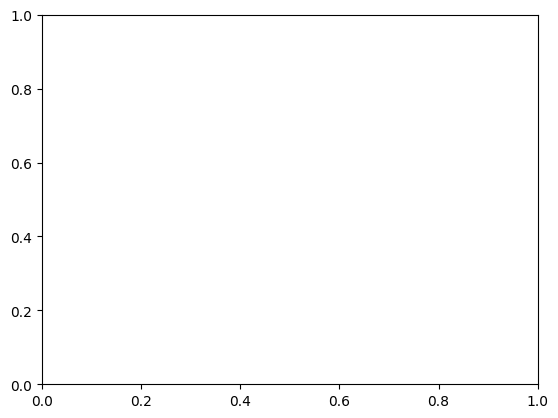

In [ ]:
fig, ax = plt.subplots()
sns.heatmap(accidents_matches.corr(method='pearson'), annot=True, fmt='1.2f',robust=False,cmap="YlOrBr")
#plt.title('On average, Tuesdays and Thursdays \n have the highest number of accidents per day per hour at 5pm.',loc='left',fontweight="light")
#ax.set(xlabel="Day", ylabel="Hour")
ax.xaxis.tick_top()
plt.xticks(rotation=60)
plt.yticks(rotation=0)
plt.show()

In [ ]:
def graficar_nro_registros_hora(station_number, anho, hora_ini,hora_fin):
  df = data[(data['MeasurementStationID'] == station_number)&(data['datetime'].dt.year == anho)&(data['Hora']<hora_fin)&(data['Hora']>=hora_ini)]
  df = df.groupby(['MeasurementStationID','Fecha']).agg({'Hora': 'count'}).reset_index()
  horas_sin_datos = df[df['Hora']<12]
  fig = calplot(df,
                x = 'Fecha',
                y = 'Hora',
                month_lines_color='black', month_lines_width = 1.5,
                colorscale='RdYlGn', showscale=True,
                total_height=110,
                title='Estación: '  + str(station2name[station_number]),
                cmap_min=0, cmap_max=12*(hora_fin-hora_ini),
                start_month=1, end_month=12,
                )
  return fig.show()

In [ ]:
acc_by_time = pd.pivot_table(peak_accidents, values='fixed', index=['Hora'],columns=['Dia_Semana'])
acc_by_time = acc_by_time[order]
acc_by_time.rename(columns=order_dict, inplace=True)

fig, ax = plt.subplots()
sns.heatmap(acc_by_time, annot=True, fmt='1.2f',robust=False,cmap="Spectral_r")
plt.title('On average, Tuesdays and Thursdays \n have the highest number of accidents per day per hour at 5pm.',loc='left',fontweight="light")
ax.set(xlabel="Day", ylabel="Hour")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()